# The question I want to answer is simple:
## Was the first two months of summer in 2020 warmer or colder than regular summer weather?

In [32]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression

Data from the year 1901 to the year 2016 is from The World Bank:

https://climateknowledgeportal.worldbank.org/download-data

In [33]:
# read file with WB-data
df = pd.read_csv('WB_Weather_Almaty.csv')
df.head()

,Temperature - (Celsius),Year,Statistics,Longitude,Latitude
0,-8.600000,1901,Jan Average,76.889709,43.238949
1,-7.900000,1901,Feb Average,76.889709,43.238949
2,4.400000,1901,Mar Average,76.889709,43.238949
3,9.400001,1901,Apr Average,76.889709,43.238949
4,13.100000,1901,May Average,76.889709,43.238949


In [34]:
# change column names
df.columns=['Temp', 'Year', 'Month', 'Longitude', 'Latitude']
df.head()

,Temp,Year,Month,Longitude,Latitude
0,-8.600000,1901,Jan Average,76.889709,43.238949
1,-7.900000,1901,Feb Average,76.889709,43.238949
2,4.400000,1901,Mar Average,76.889709,43.238949
3,9.400001,1901,Apr Average,76.889709,43.238949
4,13.100000,1901,May Average,76.889709,43.238949


In [35]:
# drop useless columns
df.drop(['Longitude', 'Latitude'], axis=1, inplace=True)
df.head()

,Temp,Year,Month
0,-8.600000,1901,Jan Average
1,-7.900000,1901,Feb Average
2,4.400000,1901,Mar Average
3,9.400001,1901,Apr Average
4,13.100000,1901,May Average


In [36]:
#correct Month column
month = []
for i in df['Month']:
    month.append(i.split(' ')[1])
df['Month'] = month
df.head()

,Temp,Year,Month
0,-8.600000,1901,Jan
1,-7.900000,1901,Feb
2,4.400000,1901,Mar
3,9.400001,1901,Apr
4,13.100000,1901,May


In [37]:
# select only the data we need for analysis
df = df[(df['Month']=='Jun') | (df['Month']=='Jul')]
df.head()

,Temp,Year,Month
5,15.800000,1901,Jun
6,20.400000,1901,Jul
17,19.400000,1902,Jun
18,19.800001,1902,Jul
29,16.600000,1903,Jun


New data comes from the other source:

https://rp5.ru/Weather_archive_in_Almaty_(airport),_METAR

In [38]:
# new data isn't organized in csv file, so I enter it manually here.
new_data = [[21.0, 2013, 'Jun'], [23.5, 2013, 'Jul'], 
            [22.6, 2014, 'Jun'], [24.3, 2014, 'Jul'],
            [22.3, 2015, 'Jun'], [26.6, 2015, 'Jul'],
            [22.4, 2016, 'Jun'], [22.9, 2016, 'Jul'],
            [21.8, 2017, 'Jun'], [25.8, 2017, 'Jul'],
            [21.5, 2018, 'Jun'], [24.6, 2018, 'Jul'],
            [21.8, 2019, 'Jun'], [26.5, 2019, 'Jul'],
            [21.8, 2020, 'Jun'], [24.1, 2020, 'Jul']]

# convert new data to a dataframe
new_data = pd.DataFrame(new_data, columns=['Temp', 'Year', 'Month'])
new_data.head()

,Temp,Year,Month
0,21.0,2013,Jun
1,23.5,2013,Jul
2,22.6,2014,Jun
3,24.3,2014,Jul
4,22.3,2015,Jun


We can check differences in the data using common periods.

In [39]:
# The temperature in the new source is always higher, so it is better to correct it
df[df['Year']>=2013]['Temp'].reset_index()['Temp']/new_data[new_data['Year']<2017]['Temp']

0    0.966667
1    0.982979
2    0.946903
3    0.967078
4    0.941704
5    0.962406
6    0.968750
7    0.986900
Name: Temp, dtype: float64

In [40]:
# we correct new values like they were taken from the World Bank data
correction = np.mean(df[df['Year']>=2013]['Temp'].reset_index()['Temp']/new_data[new_data['Year']<2017]['Temp'])

In [41]:
# apply correction
new_data['Temp'] = (new_data['Temp']*correction).round(decimals=1)
new_data.head()

,Temp,Year,Month
0,20.3,2013,Jun
1,22.7,2013,Jul
2,21.8,2014,Jun
3,23.5,2014,Jul
4,21.5,2015,Jun


In [42]:
# check if everything was ok with correction
np.mean(df[df['Year']>=2013]['Temp'].reset_index()['Temp']/new_data[new_data['Year']<2017]['Temp'])

# Once I accidentally run this piece twice and got wrong numbers, so be careful.

0.9999224805136799

In [43]:
# as data for years 2013-2016 is the same, we drop it from the new dataframe
new_data = new_data[new_data['Year']>2016]

In [44]:
# join two datasets together
df = df.append(new_data).reset_index().drop(columns='index', axis=1)
df.tail()

,Temp,Year,Month
235,23.7,2018,Jul
236,21.0,2019,Jun
237,25.6,2019,Jul
238,21.0,2020,Jun
239,23.3,2020,Jul


In [45]:
# create a column with Date
df['Date'] = '01 ' + df['Month'] + ' ' + df['Year'].astype(str)
df.head()

,Temp,Year,Month,Date
0,15.800000,1901,Jun,01 Jun 1901
1,20.400000,1901,Jul,01 Jul 1901
2,19.400000,1902,Jun,01 Jun 1902
3,19.800001,1902,Jul,01 Jul 1902
4,16.600000,1903,Jun,01 Jun 1903


In [46]:
# convert df column to datetime format
df['Date'] = pd.to_datetime(df['Date']) 
df.head()

,Temp,Year,Month,Date
0,15.800000,1901,Jun,1901-06-01
1,20.400000,1901,Jul,1901-07-01
2,19.400000,1902,Jun,1902-06-01
3,19.800001,1902,Jul,1902-07-01
4,16.600000,1903,Jun,1903-06-01


In [47]:
# we don't need Year and Month columns anymore
df.drop(columns=['Year', 'Month'], axis=1, inplace=True)
df.head()

,Temp,Date
0,15.800000,1901-06-01
1,20.400000,1901-07-01
2,19.400000,1902-06-01
3,19.800001,1902-07-01
4,16.600000,1903-06-01


In [48]:
# create df from year 2020 data
new = df[df['Date']>='2020-01-01'].set_index('Date')
new.head()

,Temp
Date,
2020-06-01,21.0
2020-07-01,23.3


In [49]:
# create df from data before the year 2020
old = df[df['Date']<'2020-01-01'].set_index('Date')
old.head()

,Temp
Date,
1901-06-01,15.800000
1901-07-01,20.400000
1902-06-01,19.400000
1902-07-01,19.800001
1903-06-01,16.600000


In [50]:
# let's compare new year data to previous years
ttest_ind(new, old)

Ttest_indResult(statistic=array([0.84609939]), pvalue=array([0.39834718]))

In [51]:
# create lists of t-statistics and p-values by years
statistic = []
p_value = []
for year in df['Date'].dt.year.unique():
    statistic.append(ttest_ind(df[df['Date'].dt.year==year].set_index('Date'), 
                              df[df['Date'].dt.year<year].set_index('Date'))[0])
    p_value.append(ttest_ind(df[df['Date'].dt.year==year].set_index('Date'), 
                            df[df['Date'].dt.year<year].set_index('Date'))[1])            

In [52]:
# only one year is different enough from the historic data to confirm the alternative hypothesis
different = []
for value in p_value:
    if value <=0.05:
        different.append(value)
else:
    pass
different

[array([0.04092086])]

In [53]:
# this code puts indexes of p-values in a list. This will help me to find the years with outliers
p_value_index = []
row_num=-1
for value in p_value:
    row_num+=1
    if value in different:
        p_value_index.append(row_num)
else:
    pass

In [54]:
# create a list of years, where p_value is <=0.05
years = []
for index in p_value_index:
    years.append(df['Date'].dt.year.unique()[index])

In [55]:
# create a dataframe with outliers
outliers = df[df['Date'].dt.year.isin(years)]
outliers

,Temp,Date
214,22.9,2008-06-01
215,24.1,2008-07-01


In [56]:
print('Outlier temperature is {:.2f}'.format(outliers['Temp'].mean()))
print('Average temperature mean is {:.2f}'.format(df['Temp'].mean()))
print('The difference to become an outlier is {:.0f}'.format((outliers['Temp'].mean()
                                                       /df['Temp'].mean()-1)*100) + ' percent')

Outlier temperature is 23.50
Average temperature mean is 21.07
The difference to become an outlier is 12 percent


In [57]:
# summer temperature for 2 months in 2020
temp_2020 = df[df['Date'].dt.year==2020]['Temp'].mean() 
temp_2020

22.15

In [58]:
# create a variable with the current difference
cur_dif = (temp_2020 / df[df['Date'].dt.year<2020]['Temp'].mean() -1)*100

In [59]:
'2020 Jun-Jul temperature differs from historical observations only by {:.1f}'.format(cur_dif) + ' percent'

'2020 Jun-Jul temperature differs from historical observations only by 5.2 percent'

In [60]:
# we need x, y to draw a linear regression line
x = df.groupby(df['Date'].dt.year).mean()['Temp'].index.values.reshape(-1,1)
y = df.groupby(df['Date'].dt.year).mean()['Temp'].values.reshape(-1,1)

In [61]:
# create and fit the model
model = LinearRegression()
model.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

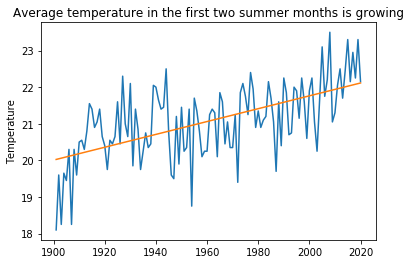

In [62]:
# plot temperature trend
fig, ax = plt.subplots()
ax.plot(df.groupby(df['Date'].dt.year).mean())
ax.plot(x, model.predict(x))
plt.ylabel('Temperature')
plt.title('Average temperature in the first two summer months is growing')
plt.savefig('Almaty_Temp_Jun_Jul.png')

## Conclusions
- The temperature in the first two months of summer 2020 wasn't abnormal enough to become an outlier with significant p-value to confirm the alternative hypothesis.
- 2/3 of 2020 summer were 5.2% warmer than previous historical data mean, but that isn't enough to become an outlier.
- Having more than 100 years of historical data, only the temperature of one year was significantly different, than previous data. It was the year 2008.
- During the 120 years, temperature trend has risen by 2 degrees or 10%. The temperature rise can seriously affect the life of local citizens and local ecosystems.